### Import required libraries

In [1]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

%matplotlib inline

### Increase the size of the screen

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Decrypt Credentials and Connect to Database

In [3]:
#Uncode the secret license file
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the normalized table

In [4]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instance_normalized', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))
    
df.drop(['index'],axis=1, inplace=True)
df.head(15)

#df.describe()
#print(df.columns)

--- 0.9004130363464355 seconds ---


duration  key_song  loudness      mode     tempo  time_signature  words_song_u    words_song  words_song_r  words_genre_u  words_genre  words_genre_r  words_second  speed_general  artist_familiarity  artist_hotttnesss  gnr_Blues  gnr_Country  gnr_Folk  gnr_Funk  gnr_House Electronic Trance  gnr_Jazz  gnr_Latin  gnr_Metal  gnr_Pop  gnr_Pop Standards  gnr_Punk  gnr_Rap Hip Hop  gnr_Rhythm and Blues  gnr_Rock  gnr_Rock and Roll  gnr_Ska Reggae Dancehall  is_top40
0   0.534987 -1.481110  0.258518  0.639234 -0.112471       -0.561806  4.235769e-01  2.955438e-01     -0.202308      -0.345508    -0.413449       0.242225      0.297769       0.899416            1.384889           0.757471          0            0         0         0                            0         0          0          0        0                  0         0                0                     0         1                  0                         0         1
1   0.002174 -0.366509  0.848227 -1.564371 -0.136996        0.335604  1.561948e-01  7.476275e-01     -0.912039      -0.066318     0.347432      -1.175246      0.621189      -0.882981            1.969000           1.591525          0            0         0         0                            0         0          0          0        1                  0         0                0                     0         0                  0                         0         1
2   1.445209  1.026743  0.808503 -1.564371 -0.273159        0.335604 -5.791060e-01 -3.502901e-01     -0.405088      -0.066318     0.347432      -1.175246      0.621189      -0.882981            1.969000           1.591525          0            0         0         0                            0         0          0          0        1                  0         0                0                     0         0                  0                         0         1
3   0.457285 -1.202460  0.135502  0.639234 -0.364445        0.335604  3.233086e-01  2.309604e-01     -0.202308      -0.205913     0.075689      -0.891752      0.085533      -0.882981            0.701760           1.031516          0            0         0         0                            0         0          0          0        0                  0         0                0                     0         0                  0                         0         1
4   1.667215  1.305393 -1.177697 -1.564371  0.222762        0.335604  1.493105e+00  2.454474e+00     -1.114820      -0.205913     0.075689      -0.891752      0.085533       0.899416            0.701760           1.031516          0            0         0         0                            0         0          0          0        0                  0         0                0                     0         0                  0                         0         1
5   0.168678 -0.645159 -0.942685 -1.564371 -1.175979        0.335604  3.233086e-01 -1.380876e-01      0.406034      -0.205913     0.075689      -0.891752      0.085533      -0.882981            1.228673           0.945052          0            0         0         0                            0         0          0          0        0                  0         0                0                     0         0                  0                         0         1
6  -0.386336  1.305393 -0.500851 -1.564371 -0.690313        0.335604  6.575363e-01  1.940556e-01      0.203253      -0.205913     0.075689      -0.891752      0.085533      -0.882981            0.701760           1.031516          0            0         0         0                            0         0          0          0        0                  0         0                0                     0         0                  0                         0         1
7   1.611713  1.026743  1.070682 -1.564371 -0.227963        0.335604 -4.749661e-16 -5.244487e-16     -0.217324      -0.066318     0.347432      -1.175246      0.621189      -0.882981            1.573319           2.457261          0            0       

### Visualize only important features 

In [5]:
#songs = df[['decade', 'duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', \
#            'words_song_u','words_song', 'words_song_r', 'words_genre_u','words_genre','words_genre_r','words_second',\
#            'speed_general', 'artist_familiarity', 'artist_hotttnesss', \
#            'gnr_Metal','is_top40']]
songs = df [['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', 'words_song', \
             'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'speed_general', \
             'artist_familiarity', 'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall', 'is_top40']]

### Correlation Matrix Plot

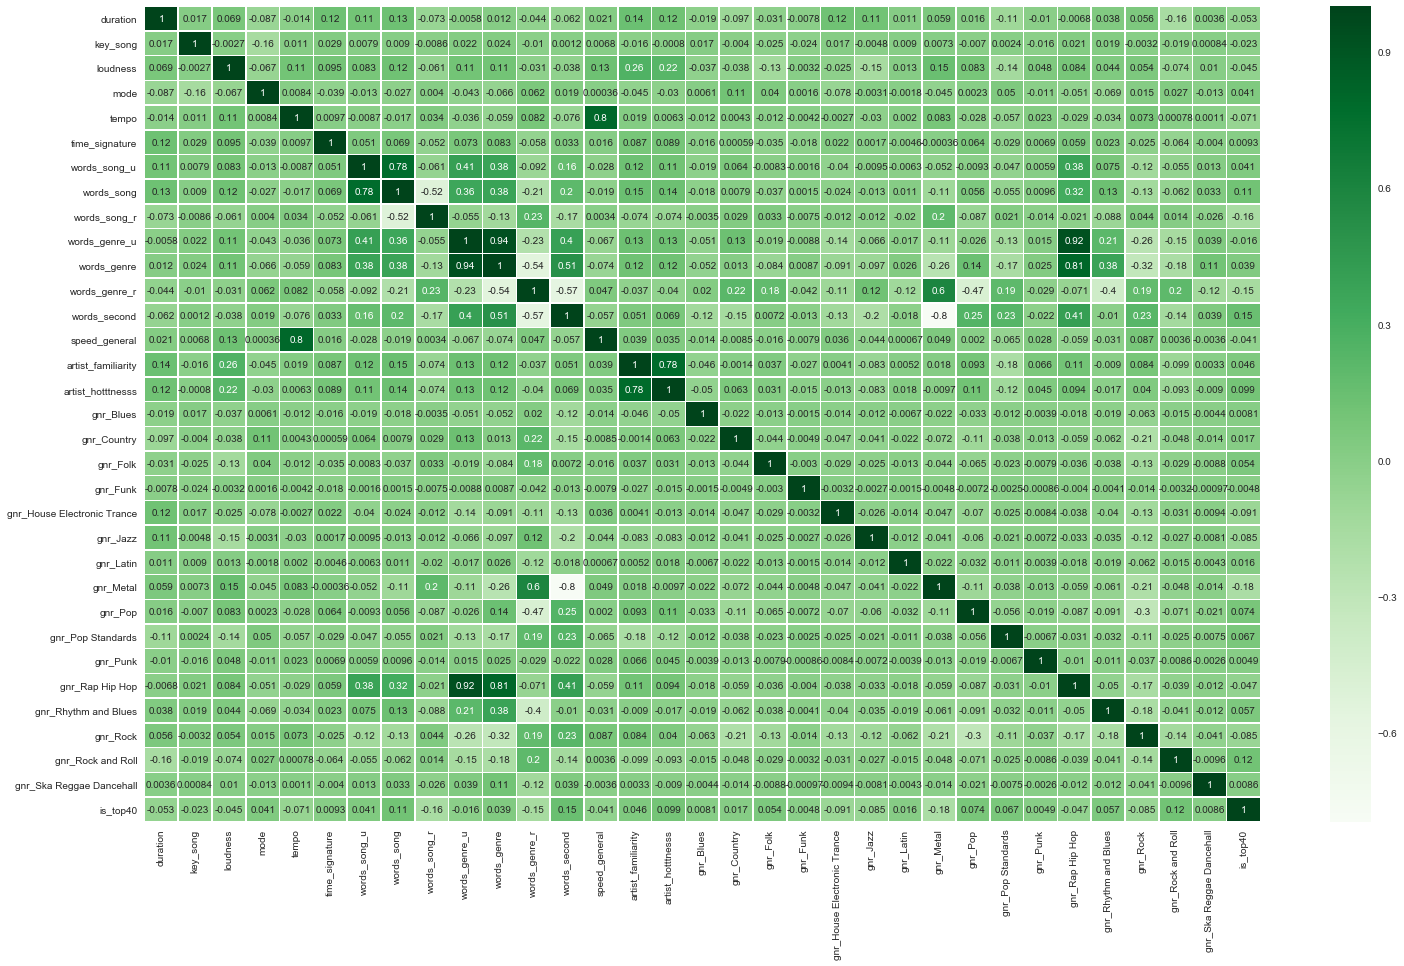

In [17]:
import seaborn as sns
corr = songs.corr()
fig, ax = plt.subplots(figsize=(25,15)) 
ax=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, linewidths=.5, cmap="Greens")
plt.show()

### Scatterplot

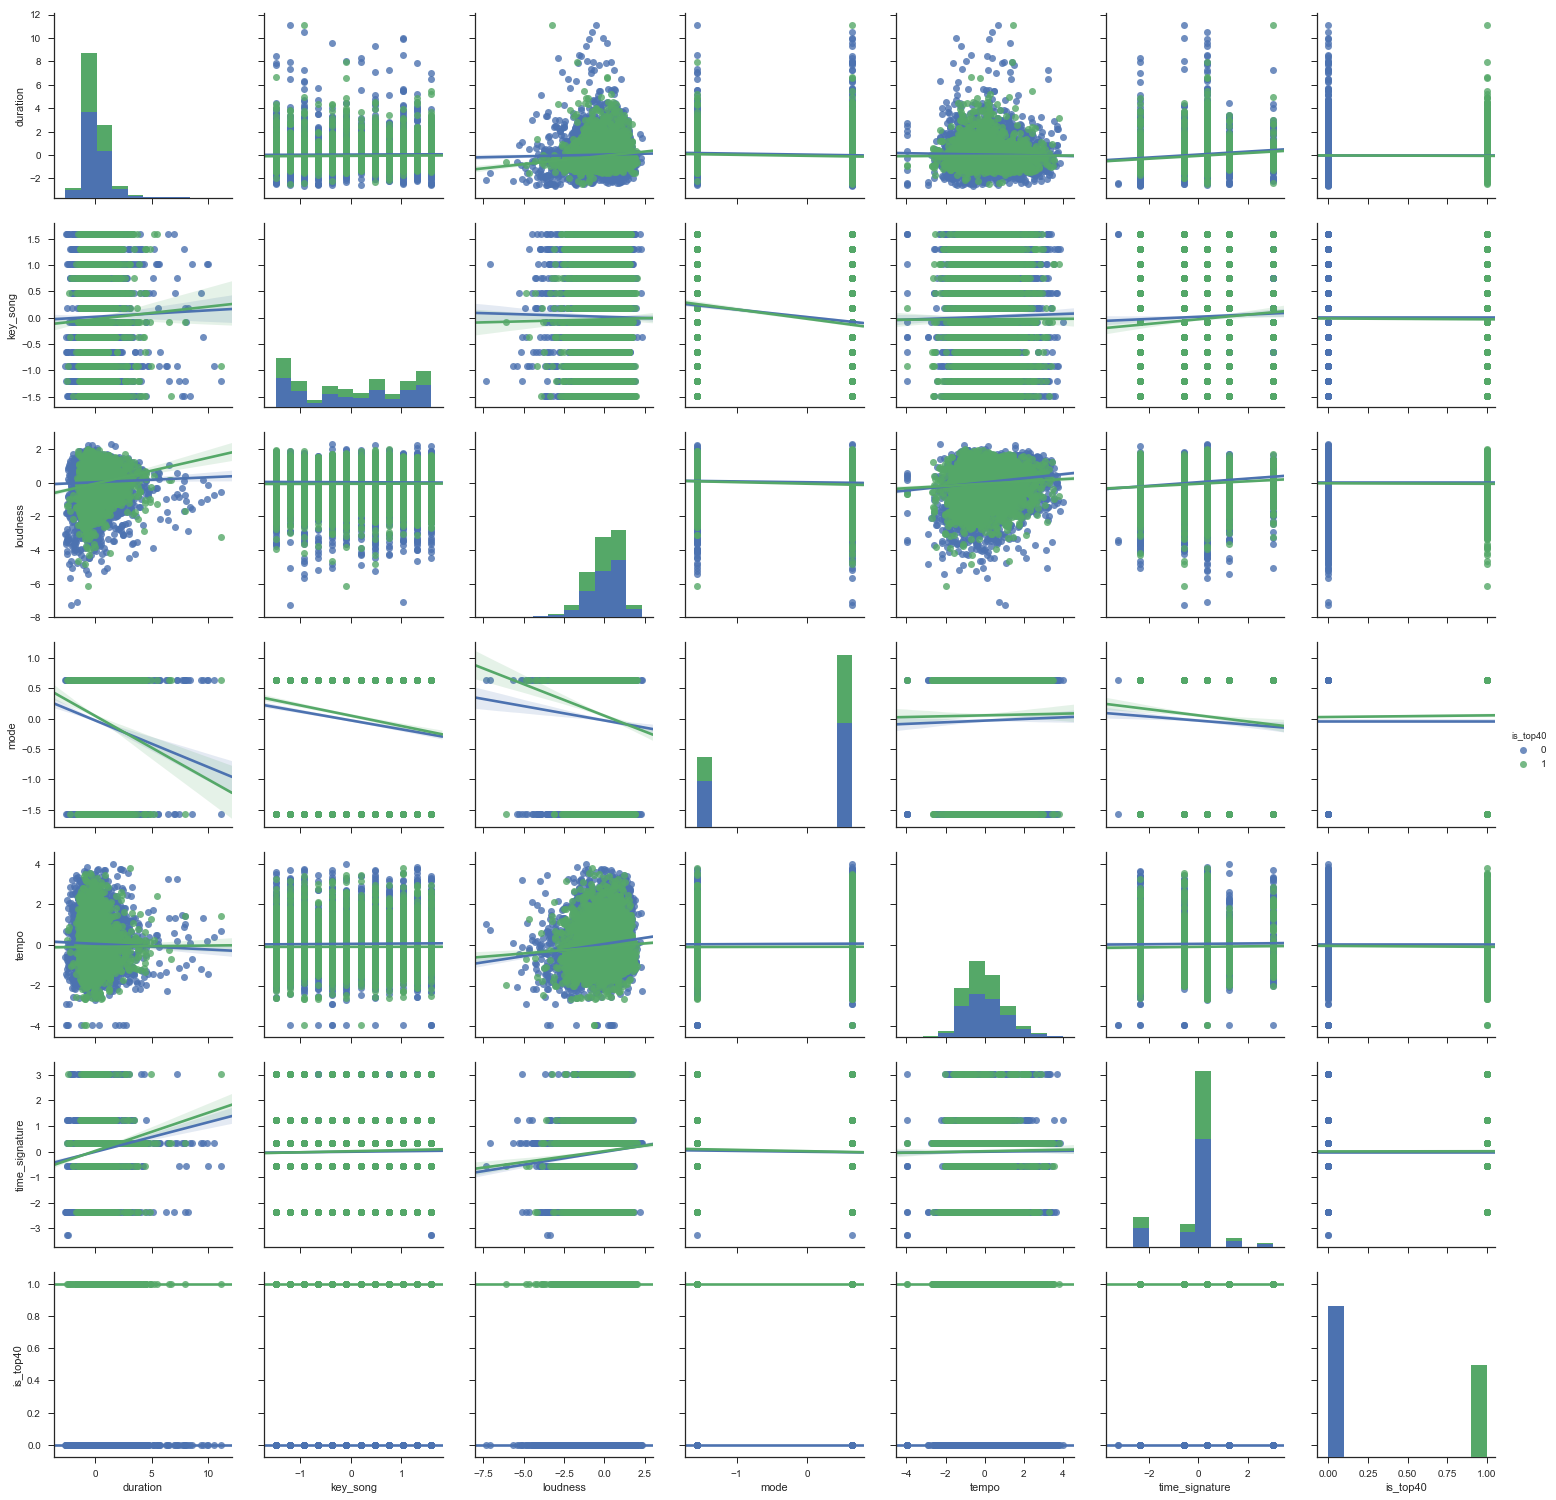

In [19]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['duration', 'key_song', 'loudness', 'mode', 'tempo', \
                                      'time_signature','is_top40'], kind="reg")

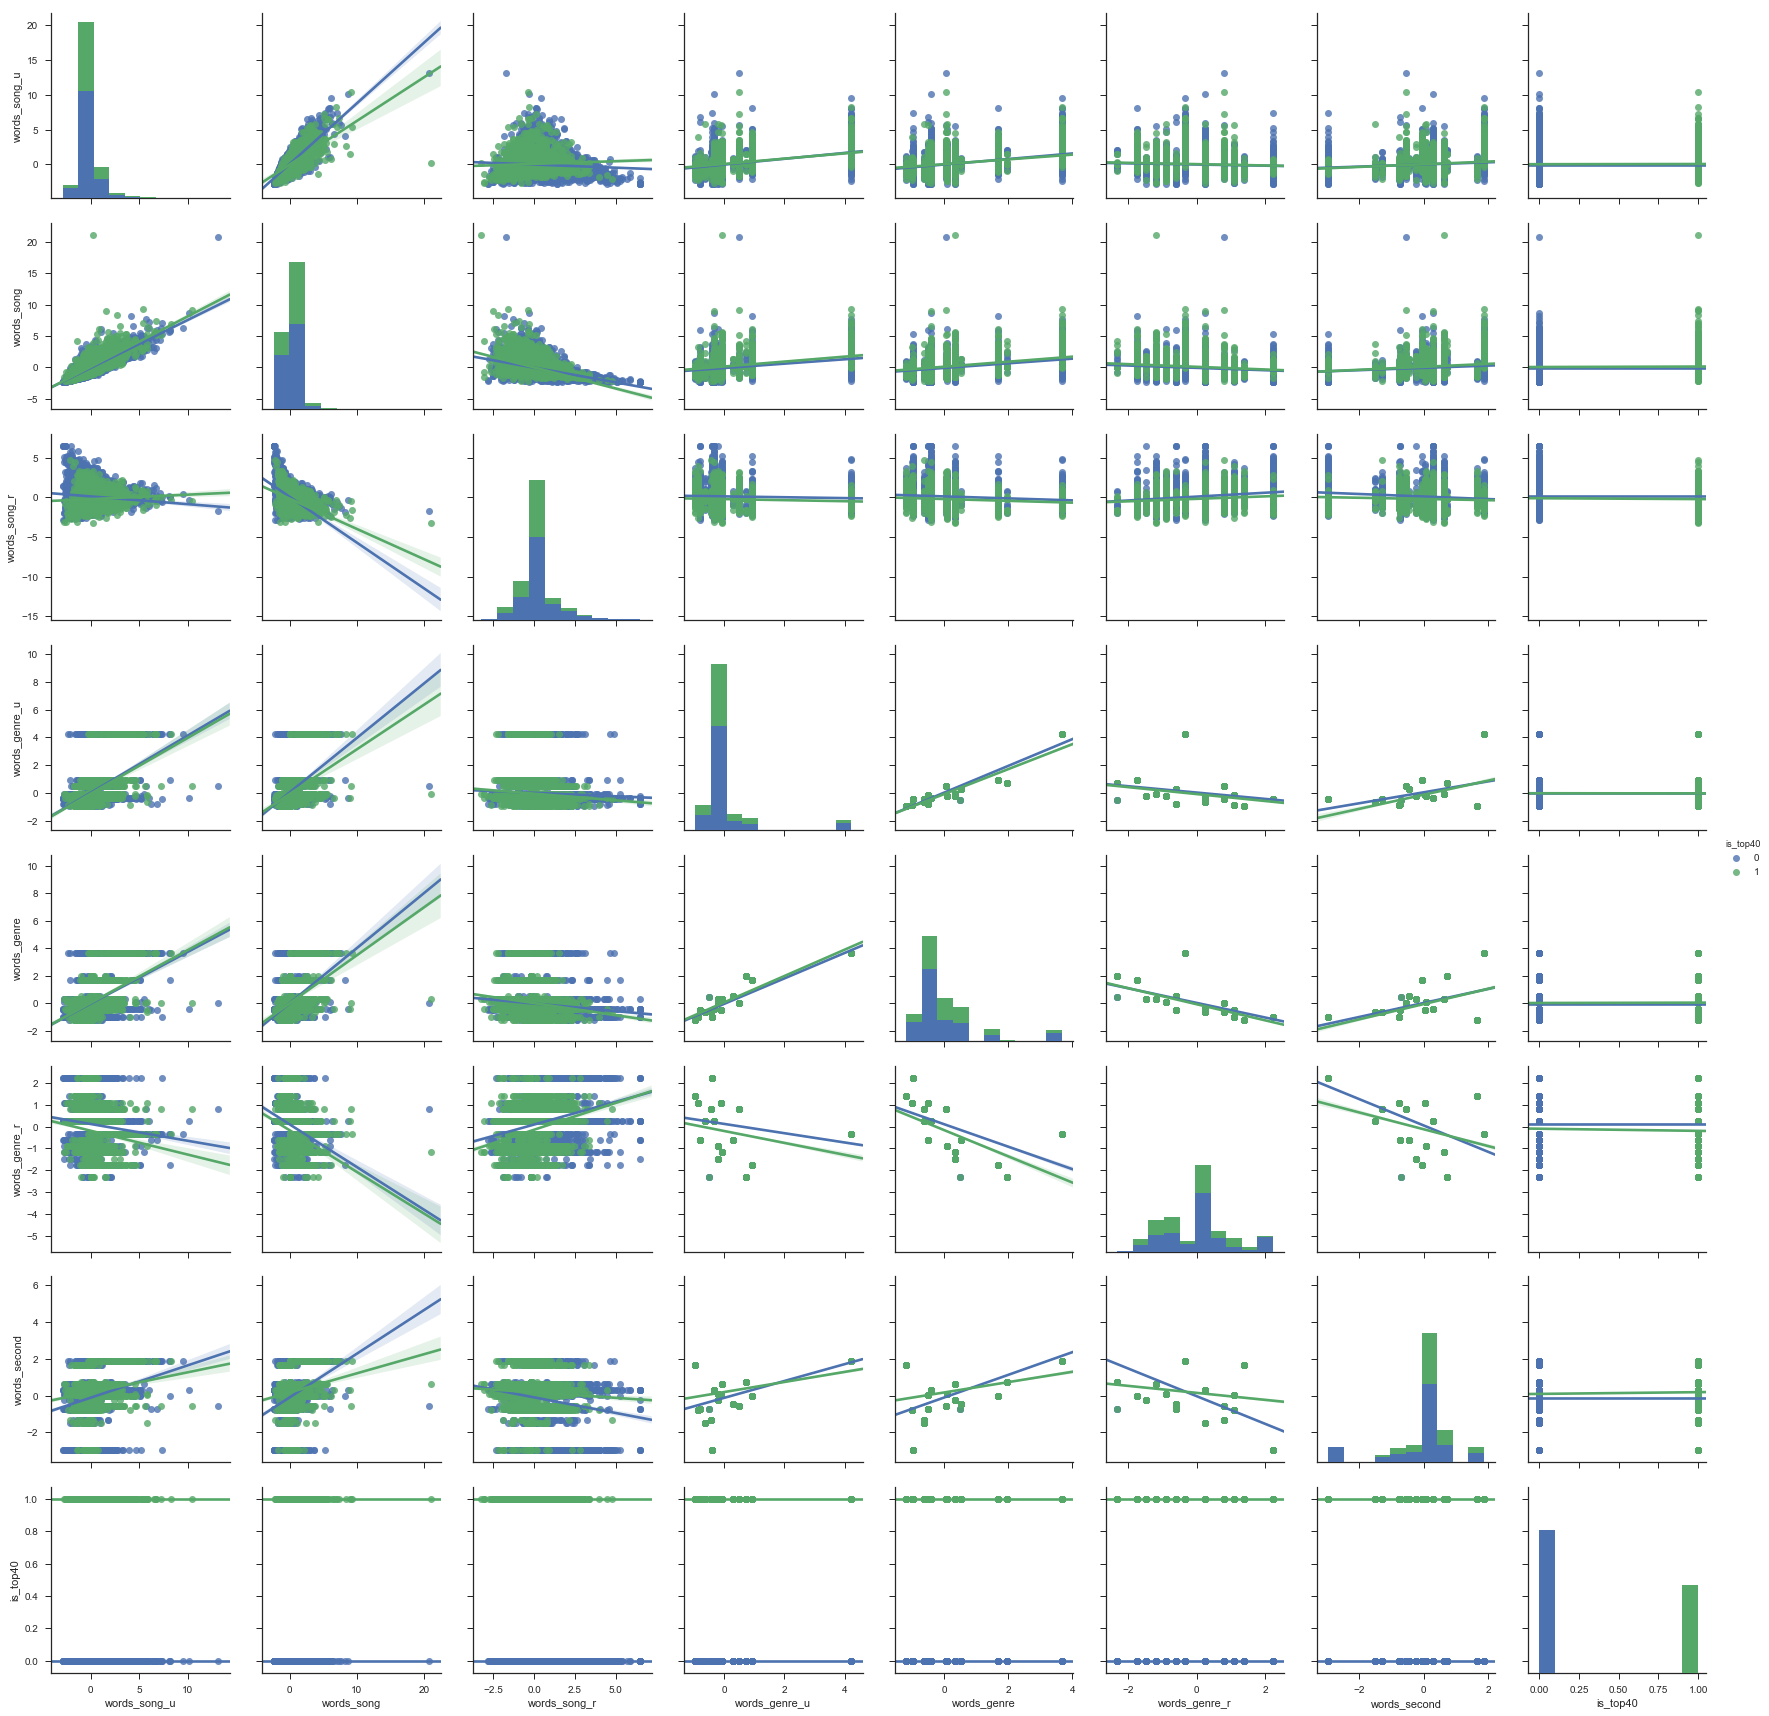

In [20]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['words_song_u','words_song', 'words_song_r', 'words_genre_u','words_genre',\
                                      'words_genre_r','words_second','is_top40'], kind="reg")

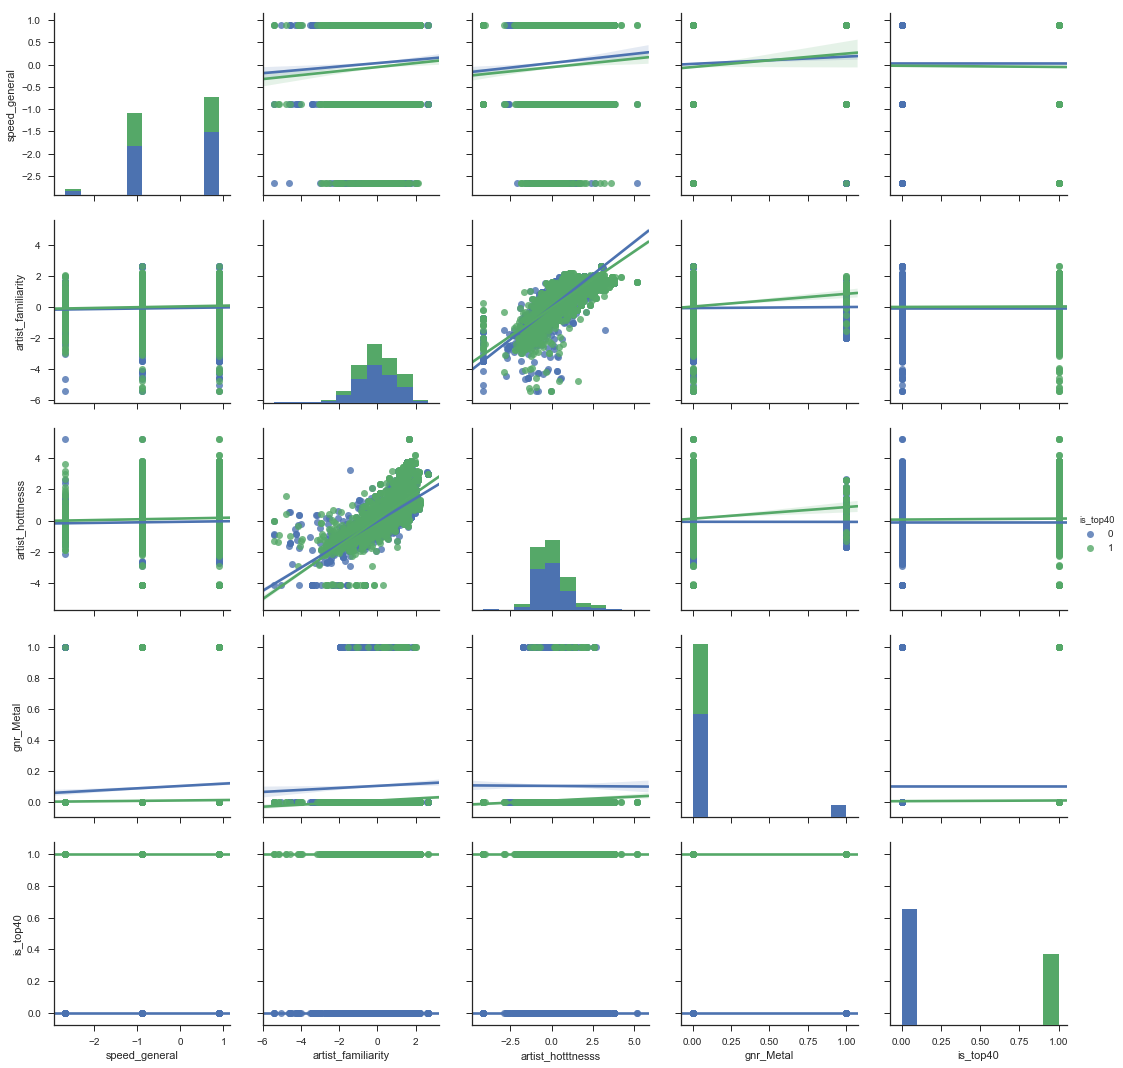

In [21]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs,hue='is_top40', size=3, vars=['speed_general', 'artist_familiarity', 'artist_hotttnesss', \
            'gnr_Metal','is_top40'], kind="reg")

### Scatter Matrix

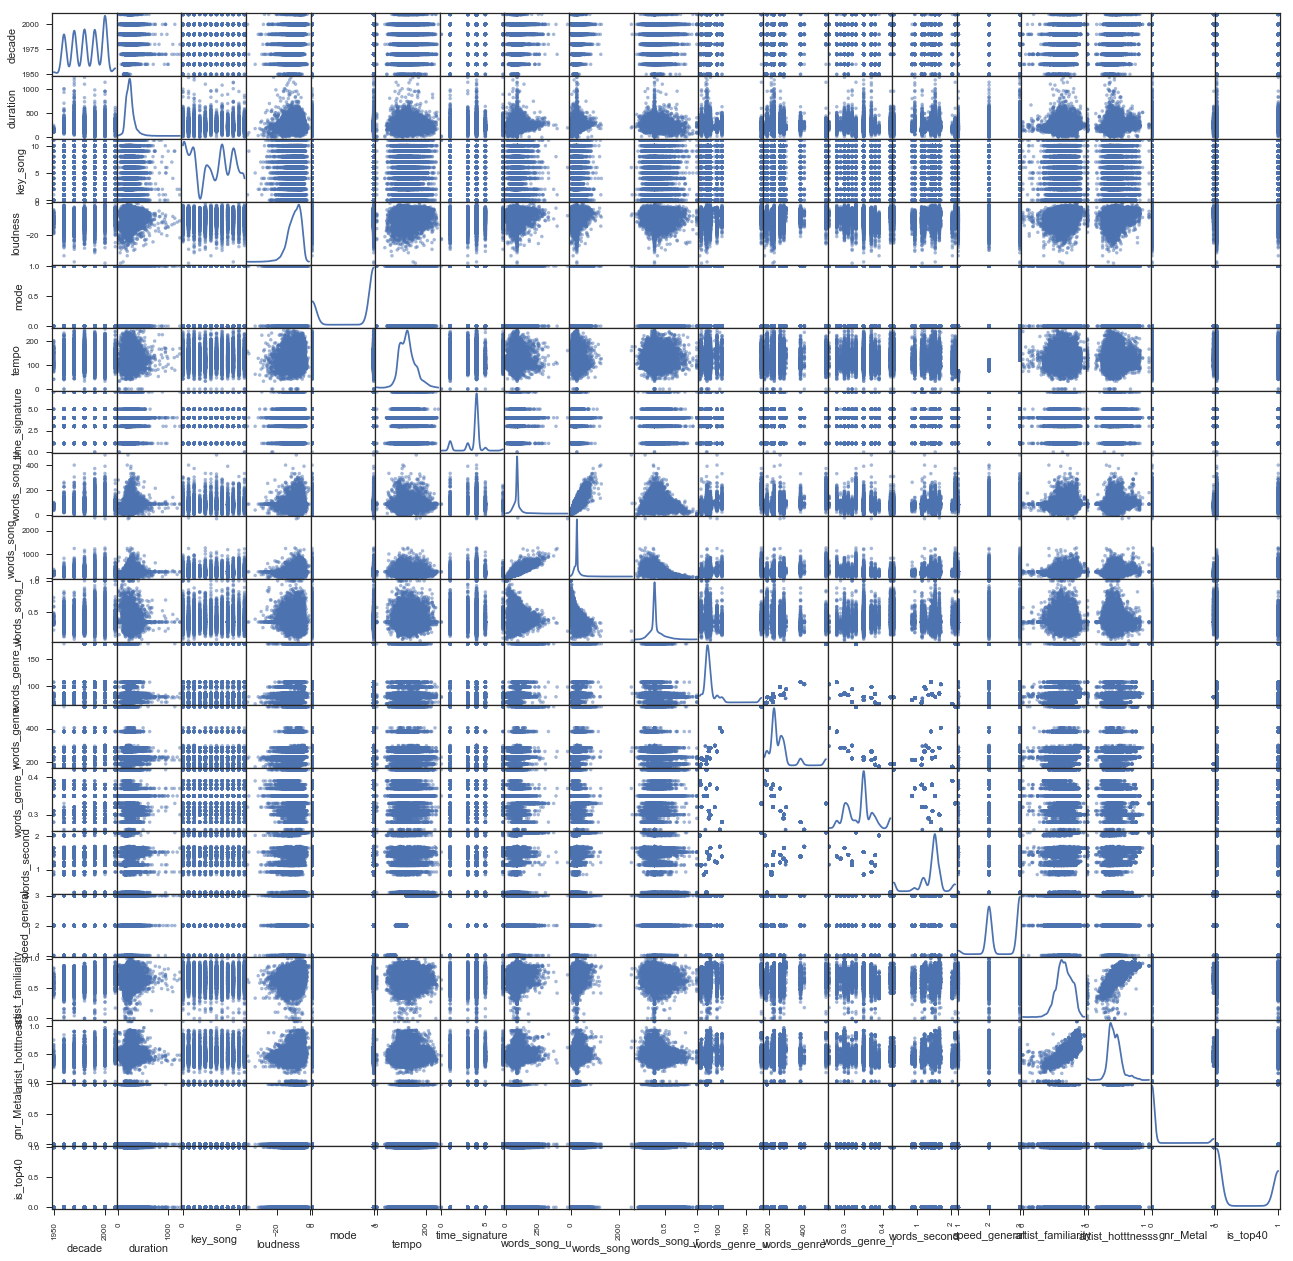

In [21]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
scatter_matrix(songs, alpha=0.5, figsize=(22, 22), diagonal='kde')
plt.show()

### Kernel Density Estimation Plots

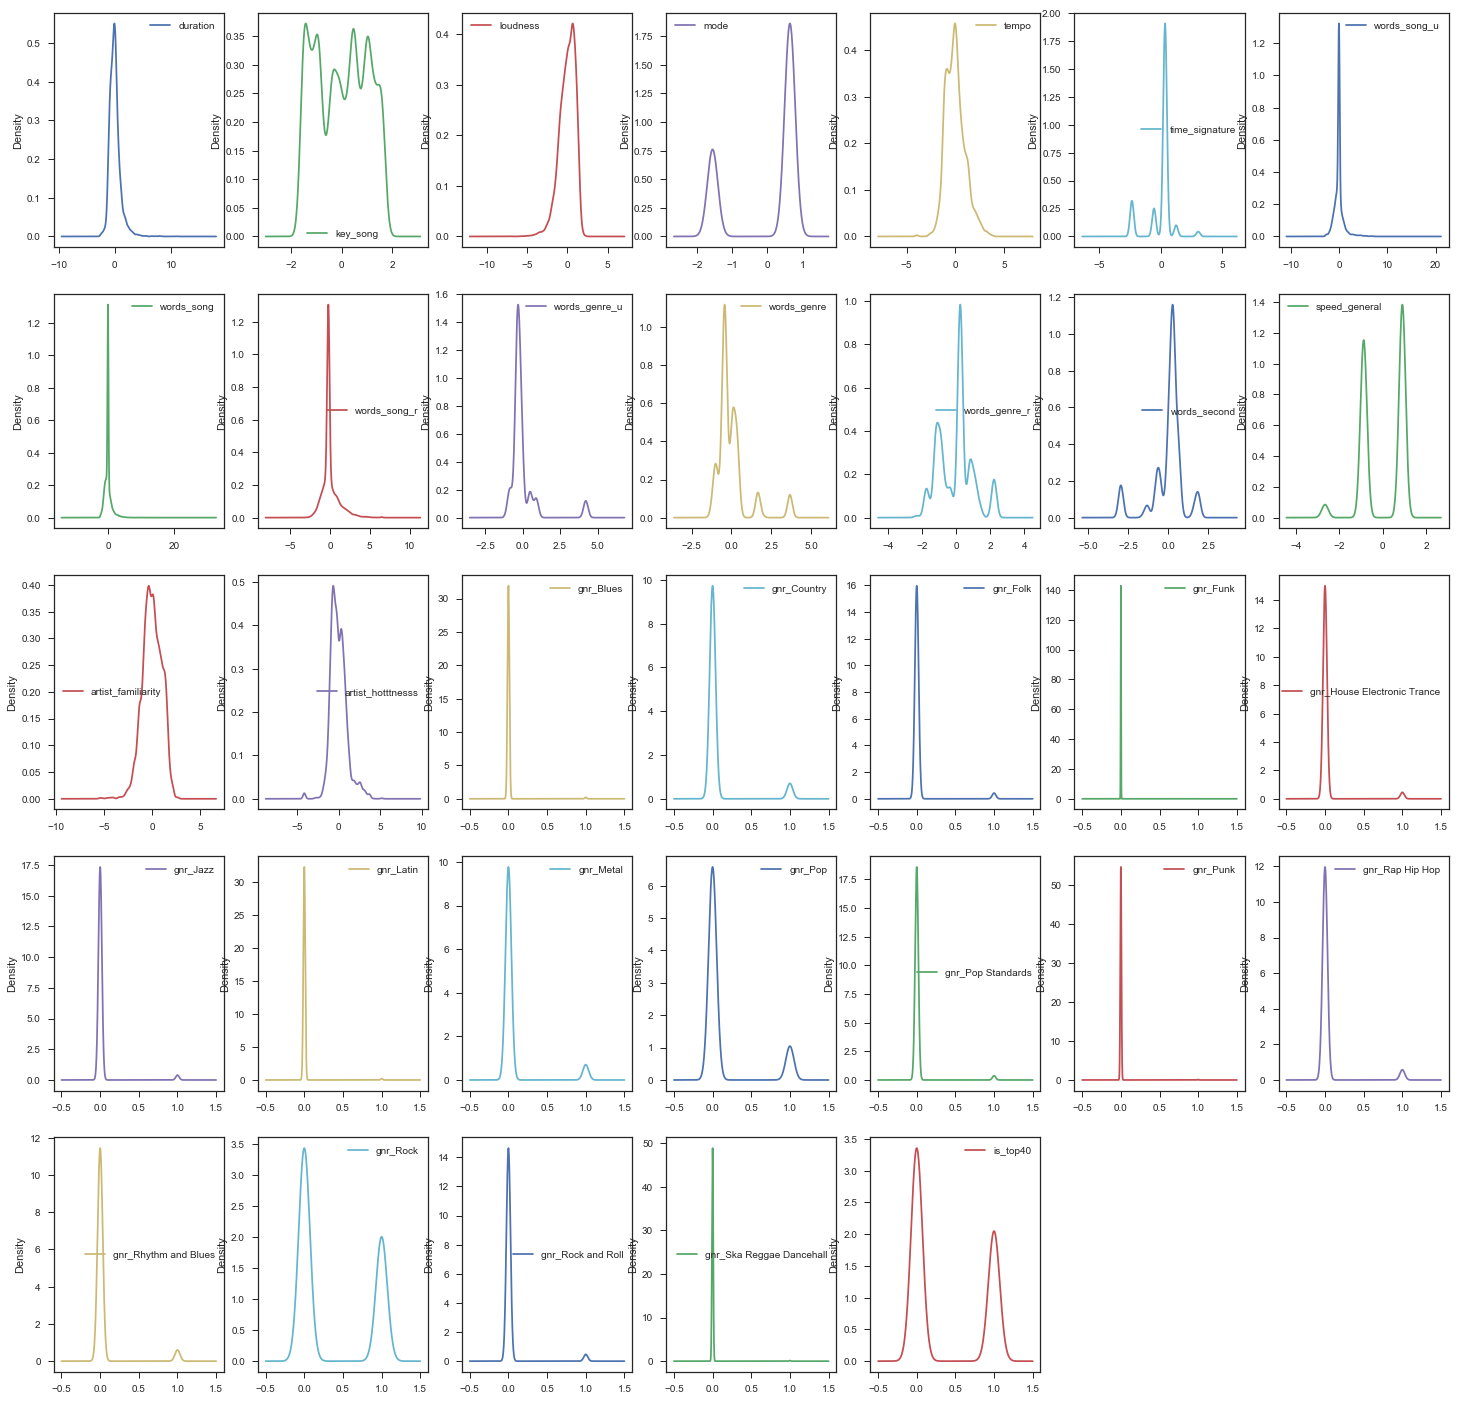

In [22]:
songs.plot(kind='kde', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(25,25))
plt.show()

### Box Plots 

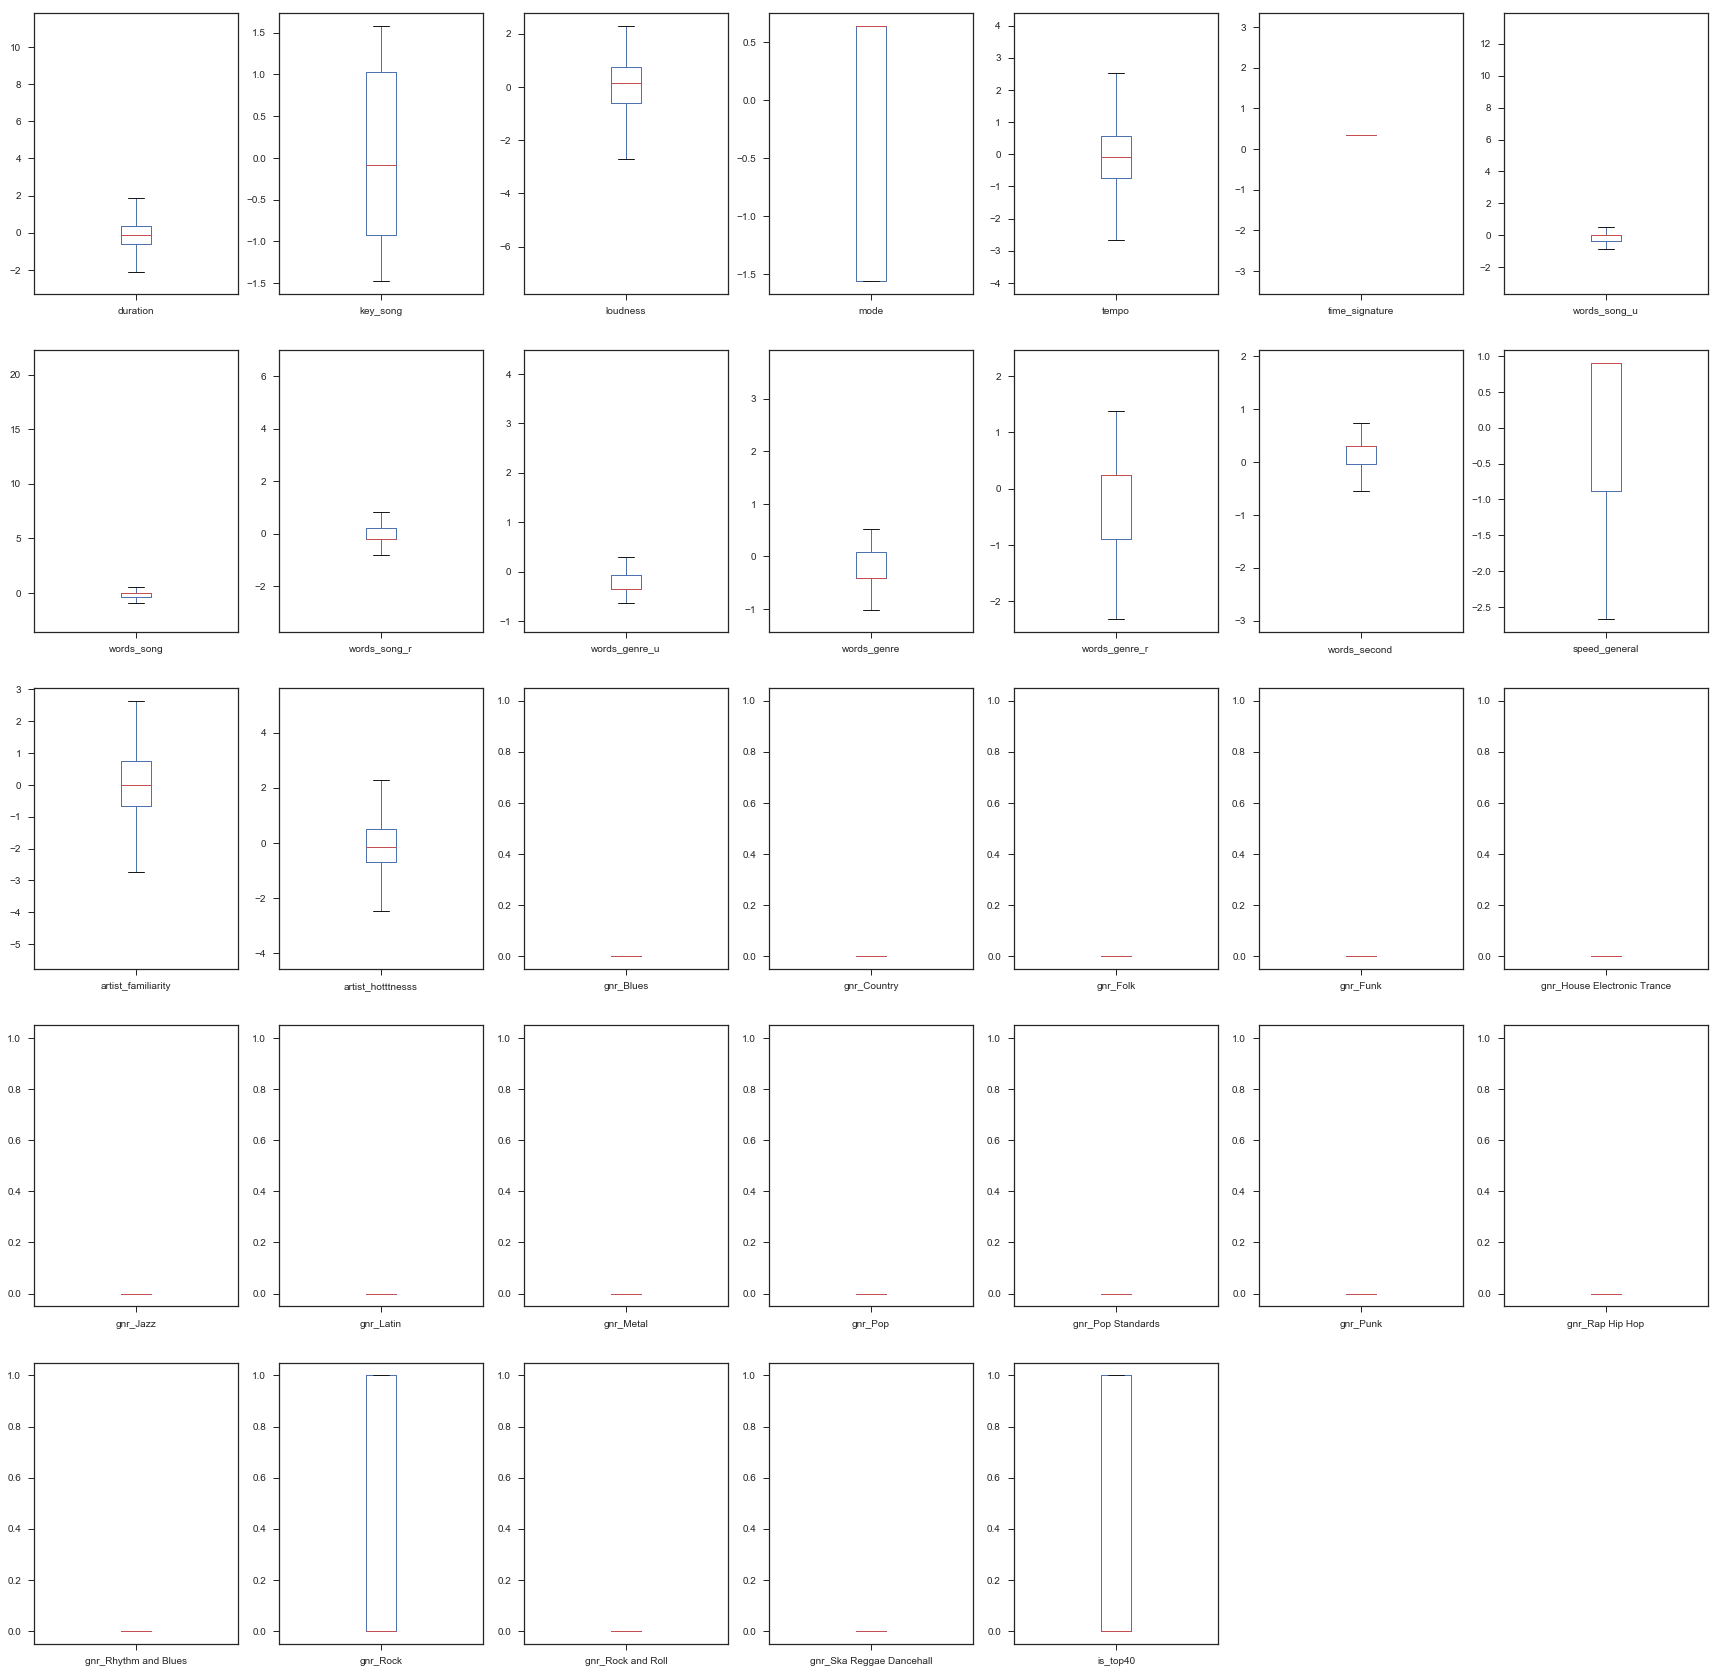

In [23]:
songs.plot(kind='box', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(30,30))
plt.show()

### Parallel Coordinates

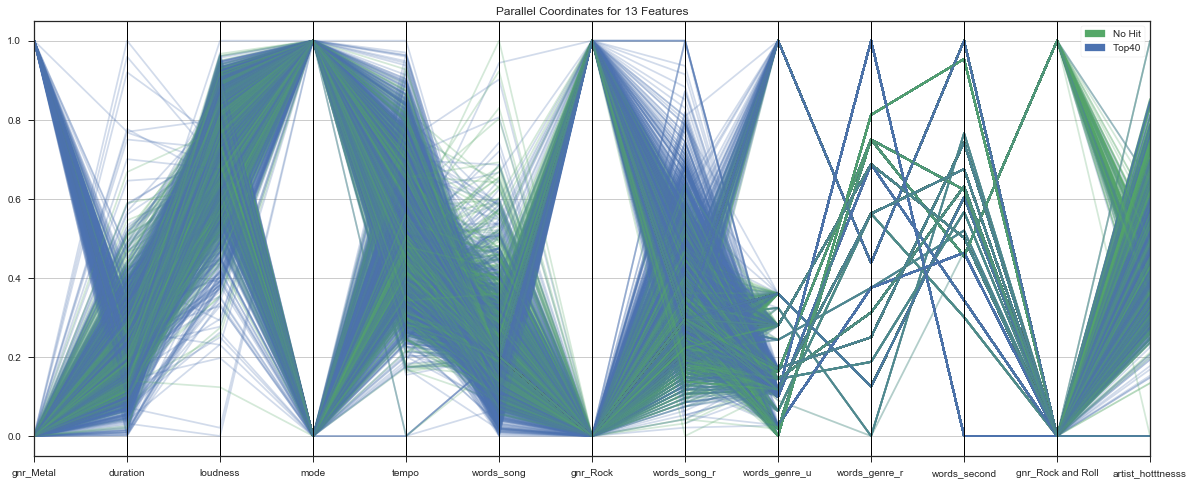

In [26]:
#from pandas.plotting import parallel_coordinates
#plt.figure(figsize=(20,5))
#dataset = df[['loudness','mode','duration','time_signature','tempo','key_song','is_top40']]
#parallel_coordinates(songs, 'is_top40',color=['r','b'], alpha=0.45)
#plt.show()
#songs.columns
from yellowbrick.features import ParallelCoordinates
# features = ['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', \
#             'words_song', 'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 
#             'speed_general', 'artist_familiarity', 'artist_hotttnesss', 'gnr_Metal']
classes = ["Top40", "No Hit"]

features = [ 'gnr_Metal','duration', 'loudness', 'mode', 'tempo', 'words_song','gnr_Rock', 'words_song_r', 'words_genre_u', 'words_genre_r',\
            'words_second',  'gnr_Rock and Roll', 'artist_hotttnesss']
X = songs[features]
y = songs.is_top40
_, ax = plt.subplots(figsize=(20,8))
# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, normalize='minmax',sample=0.5, shuffle=True
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(X, y)

# Finalize the title and axes then display the visualization
visualizer.poof()

### Rad Viz

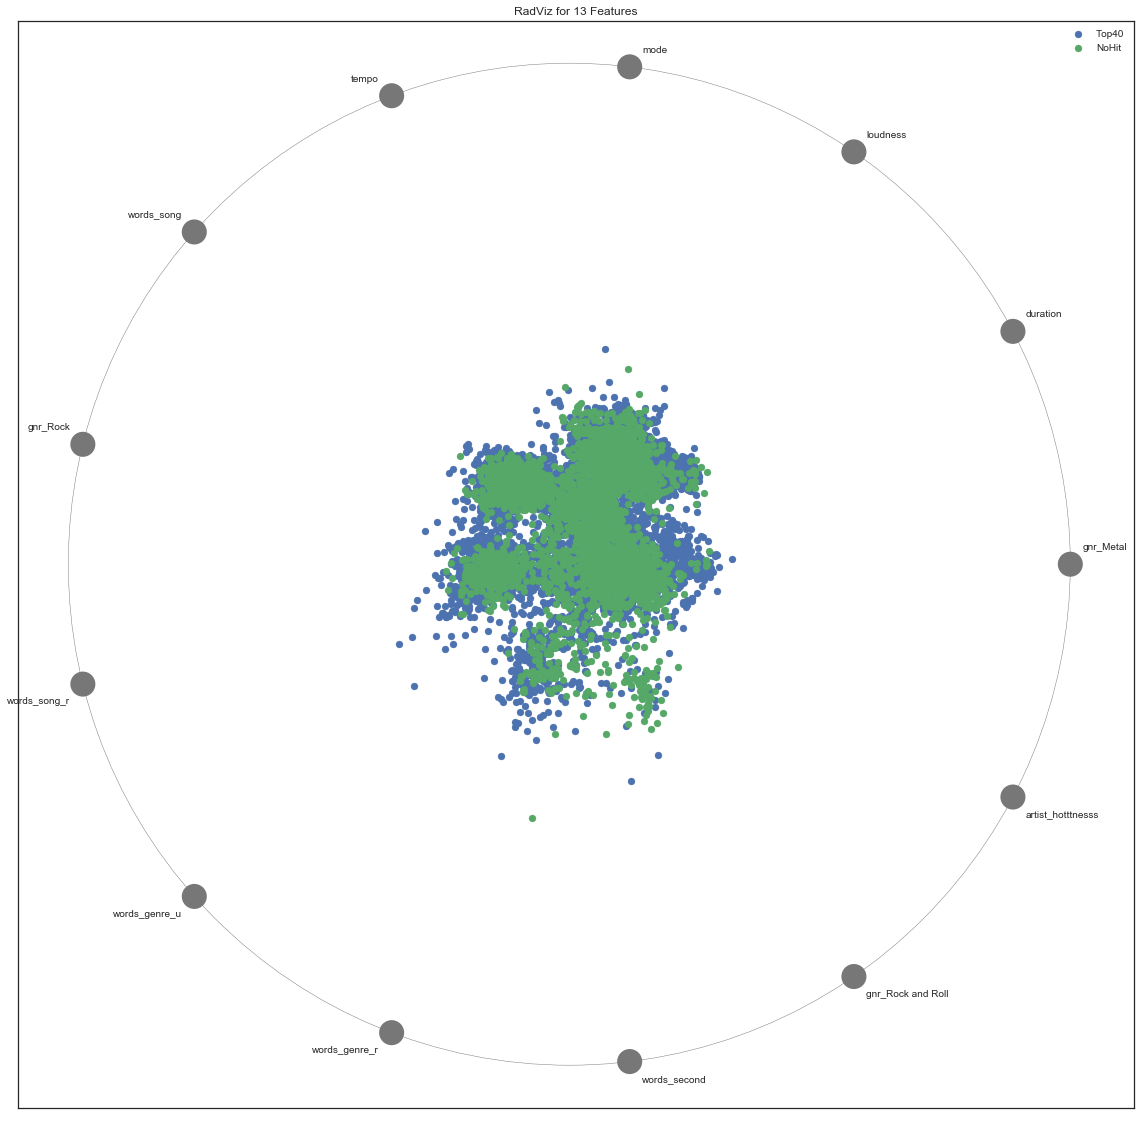

In [30]:
# Specify the features of interest and the classes of the target
classes = ["Top40", "NoHit"]
# Extract the numpy arrays from the data frame
X = songs[features].as_matrix()
y = songs.is_top40.as_matrix()
# Import the visualizer
from yellowbrick.features import RadViz

# Instantiate the visualizer
_,ax = plt.subplots(figsize=(20,20))
visualizer = RadViz(classes=classes, features=features)

visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.transform(X)   # Transform the data
visualizer.poof()         # Draw/show/poof the data

# Initial Model Comparison

### Split-Out validation dataset

In [6]:
array = songs.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40
    
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

  ### Test options and evaluation metric

In [48]:
seed = 7
# scoring = 'accuracy'
scoring = 'accuracy'

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.ensemble import AdaBoostClassifier

### Selected Algorithms

In [51]:
models = []
# #Classification Models
# #Naive Bayes
# models.append(('NB', GaussianNB(priors=None)))
# models.append(('BNB', BernoulliNB(alpha=1.0)))
# #Decision Tree
# models.append(('CART',DecisionTreeClassifier(criterion = 'entropy', splitter='random', max_depth = 10)))
# models.append(('RFC', RandomForestClassifier(n_estimators=10,max_depth=10)))
# #Discriminant Analysis
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('QDA', QuadraticDiscriminantAnalysis()))

# #LogisticRegression
# models.append(('LRG', LogisticRegression()))
# models.append(('LCV', LogisticRegressionCV()))

# #KNN
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('NCT', NearestCentroid()))
# #models.append(('KNN', NearestNeighbors()))
# models.append(('RNC', RadiusNeighborsClassifier(radius=5.0, outlier_label=1)))
# #Support Vector Machine
# models.append(('SVM', SVC())) 
# models.append(('NuSVM', NuSVC())) 
# #kernel="linear", C=0.025)))
# models.append(('LinearSVC', LinearSVC())) #kernel="linear", C=0.025)))
              
# models.append(('ABC',AdaBoostClassifier()))


DecisionTreeClassifier().get_params(deep = True)
alpha_spc = np.linspace(1,12,num=12, endpoint=True)
for a in range(len(alpha_spc)):
    models.append(('CART'+str(int(alpha_spc[a])),DecisionTreeClassifier(criterion = 'entropy', splitter='random', max_depth = int(alpha_spc[a]))))
    print(str(int(alpha_spc[a])))



1
2
3
4
5
6
7
8
9
10
11
12


### Initial Evaluation Each Model in Turn

In [52]:
results = []
names = []
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=12, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)'% (name, cv_results.mean(), cv_results.std())
    print(msg)
    print('--- %s seconds ---' % (time.time() - start_time))

CART1: 0.620971 (0.014039)
--- 0.04462003707885742 seconds ---
CART2: 0.623011 (0.012260)
--- 0.05995607376098633 seconds ---
CART3: 0.631273 (0.015913)
--- 0.07251310348510742 seconds ---
CART4: 0.623113 (0.015185)
--- 0.08935189247131348 seconds ---
CART5: 0.631579 (0.020050)
--- 0.10035085678100586 seconds ---
CART6: 0.635455 (0.016541)
--- 0.11334800720214844 seconds ---
CART7: 0.645859 (0.015844)
--- 0.1260230541229248 seconds ---
CART8: 0.656569 (0.015915)
--- 0.1402599811553955 seconds ---
CART9: 0.653917 (0.024480)
--- 0.14820361137390137 seconds ---
CART10: 0.657385 (0.013716)
--- 0.15922188758850098 seconds ---
CART11: 0.655345 (0.019077)
--- 0.17315196990966797 seconds ---
CART12: 0.658507 (0.014160)
--- 0.18333911895751953 seconds ---


### Compare Algorithms

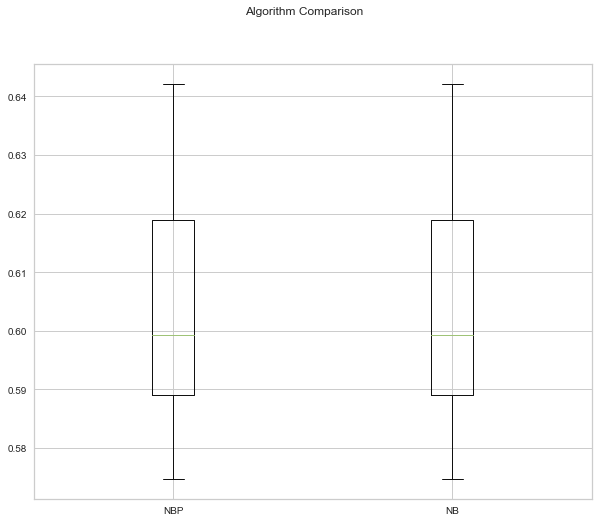

In [14]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Applying the Visualization to the Models

NB
0.5671154630762953
[[561 960]
 [101 829]]


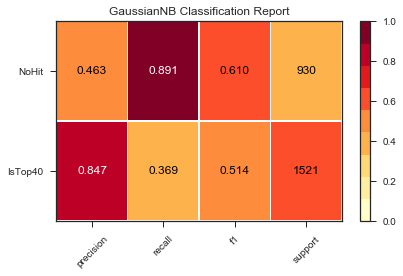

BNB
0.6360669114647083
[[1078  443]
 [ 449  481]]


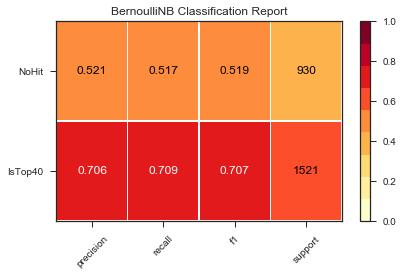

CART
0.6230110159118727
[[1076  445]
 [ 479  451]]


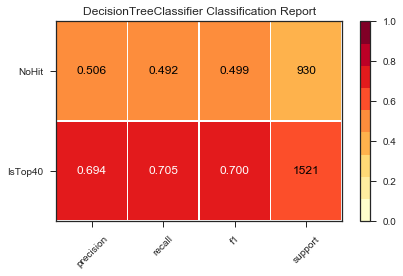

RFC
0.6719706242350061
[[1300  221]
 [ 583  347]]


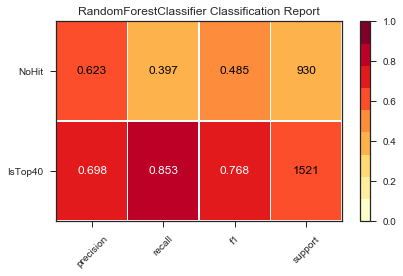

LDA
0.6654426764585883
[[1279  242]
 [ 578  352]]


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


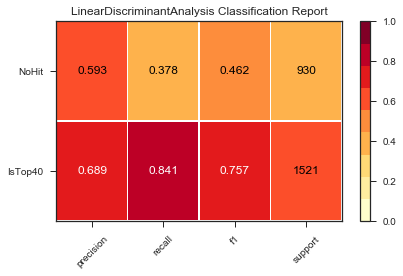

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA
0.5369237046103631
[[647 874]
 [261 669]]


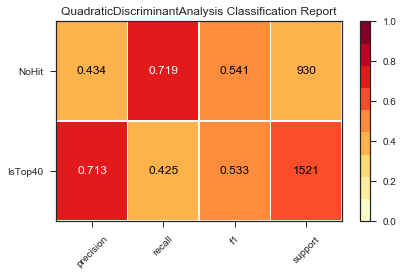

LRG
0.6609547123623011
[[1274  247]
 [ 584  346]]


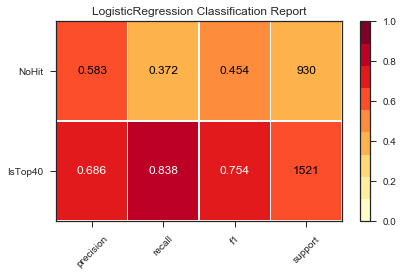

LCV
0.6593227254181967
[[1275  246]
 [ 589  341]]


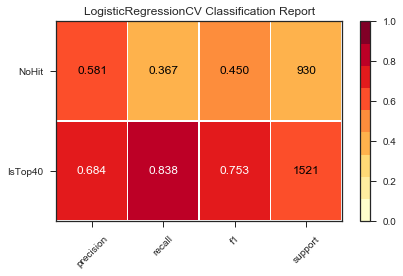

KNN
0.6483068135454917
[[1132  389]
 [ 473  457]]


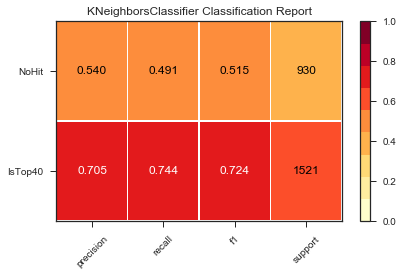

NCT
0.5989392084863321
[[884 637]
 [346 584]]


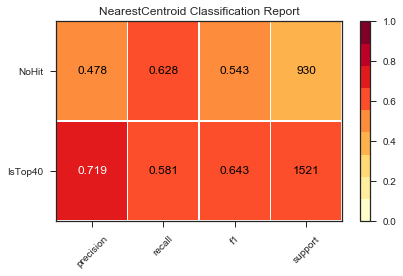

RNC
0.6258669930640555
[[1506   15]
 [ 902   28]]


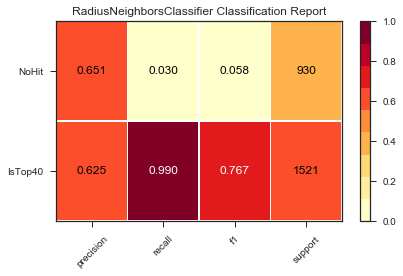

SVM
0.67156262749898
[[1301  220]
 [ 585  345]]


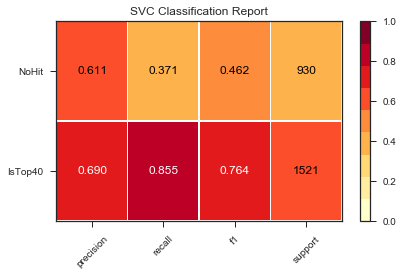

NuSVM
0.6556507547939616
[[1152  369]
 [ 475  455]]


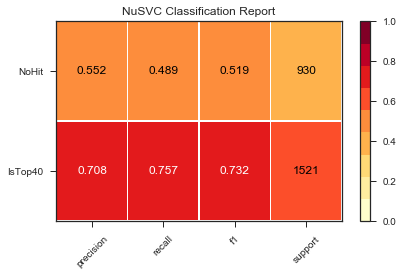

LinearSVC
0.6638106895144839
[[1283  238]
 [ 586  344]]


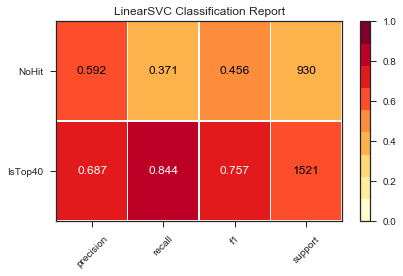

ABC
0.6625866993064056
[[1231  290]
 [ 537  393]]


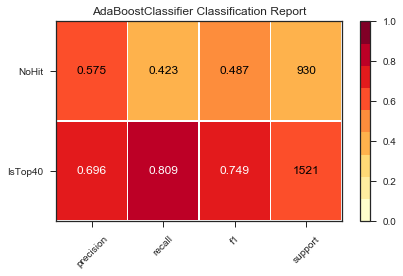

In [60]:
from yellowbrick.classifier import ClassificationReport
classes = ["IsTop40", "NoHit"]
def plotting(name, model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, Y_train)  # Fit the visualizer and the model
    visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data
    
for name, model in models:
    plotting(name, model)

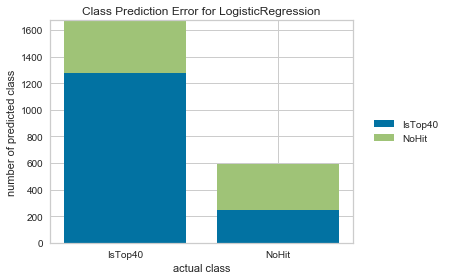

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


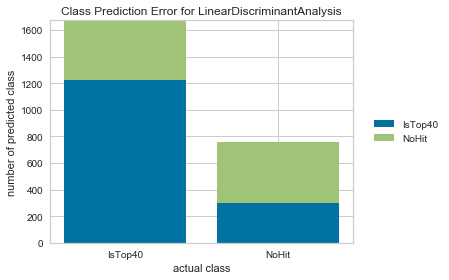

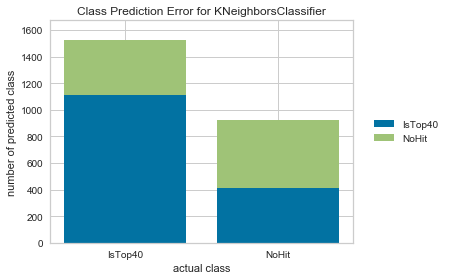

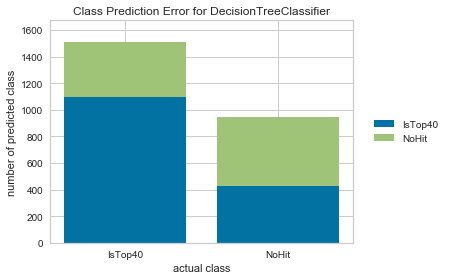

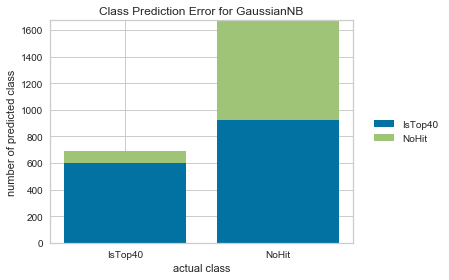

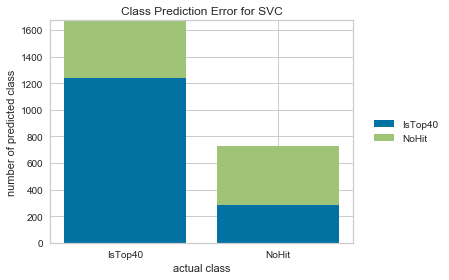

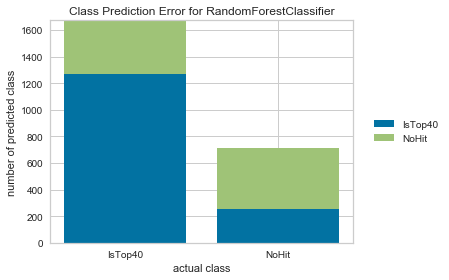

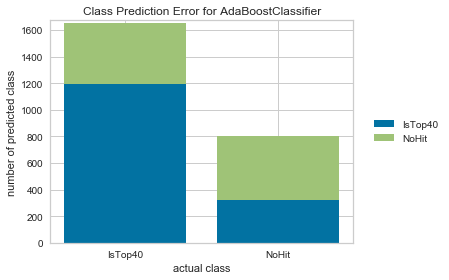

In [41]:
from sklearn.linear_model import Lasso
from yellowbrick.classifier import ClassPredictionError

def vizerror(name, model):
    # Instantiate the visualizer
    visualizer = ClassPredictionError(
        model, classes=classes)
    # Fit
    visualizer.fit(X_train, Y_train)
    # Score and visualize
    visualizer.score(X_validation, Y_validation)
    visualizer.poof()
    
for name, model in models:
    vizerror(name, model)